In [1]:
# Importing the libraries
import torch
#from torchviz import make_dot
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
exectution = "Network_Full_Generation_Full"
sc = "sc01"
period = "2030"
train_size = 0.8

In [9]:
#Read the data from desired execution
df_in = pd.read_csv("Data/input_f_sc01_Network_Line_Out_Node_1_Node_2_cac3_2030.csv",header=[0,1])
df_out = pd.read_csv("Data/input_f_sc01_Network_Line_Out_Node_1_Node_2_cac3_2030.csv",header=[0,1])

#Drop the first row because its useless 
df_in = df_in.drop([0])
df_out = df_out.drop([0])

#Focus for now only on the real part of the input data: 
df_in = df_in["Value_R"]
df_out = df_out["Value"]

#Convert to numpy array and normalize the columns of the input, sum the columns of the output: 
np_in = df_in.to_numpy()
np_in = np_in/np.abs(np_in.max(axis=0))
np_out = df_out.to_numpy().sum(axis=1)

#Convert to torch tensors
t_in = torch.from_numpy(np_in)
t_out = torch.from_numpy(np_out)

#And split into train and test set: 
train_size = 0.8
nb_train = int(train_size*len(t_out))
tr_in,te_in = t_in[:nb_train],t_in[nb_train:]
tr_out,te_out = t_out[:nb_train],t_out[nb_train:]

tr_in,te_in,tr_out,te_out= train_test_split(t_in,t_out,test_size=0.3,shuffle=False)


KeyError: 'Value'

In [10]:
df_in

,ESS1,Node_1,Node_1_Node_1,Node_1_Node_2,Node_1_Node_3,Node_2,Node_2_Node_1,Node_2_Node_2,Node_2_Node_3,Node_3,Node_3_Node_1,Node_3_Node_2,Node_3_Node_3,SolarPV_1,WindFarm_1
1,0.05,0.020000,6.714904,-2.936948,-3.777956,0.038000,-2.936948,5.873895,-2.936948,0.080000,-3.777956,-2.936948,6.714904,0.0,0.039269
2,0.05,0.018806,6.714904,-2.936948,-3.777956,0.036586,-2.936948,5.873895,-2.936948,0.080779,-3.777956,-2.936948,6.714904,0.0,0.036176
3,0.05,0.017910,6.714904,-2.936948,-3.777956,0.034082,-2.936948,5.873895,-2.936948,0.082229,-3.777956,-2.936948,6.714904,0.0,0.033555
4,0.05,0.017612,6.714904,-2.936948,-3.777956,0.031849,-2.936948,5.873895,-2.936948,0.084907,-3.777956,-2.936948,6.714904,0.0,0.032192
5,0.05,0.017612,6.714904,-2.936948,-3.777956,0.030226,-2.936948,5.873895,-2.936948,0.091965,-3.777956,-2.936948,6.714904,0.0,0.030223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8732,0.05,0.025789,6.714904,-2.936948,-3.777956,0.047046,-2.936948,5.873895,-2.936948,0.093462,-3.777956,-2.936948,6.714904,0.0,0.069384
8733,0.05,0.024991,6.714904,-2.936948,-3.777956,0.047125,-2.936948,5.873895,-2.936948,0.091795,-3.777956,-2.936948,6.714904,0.0,0.068662
8734,0.05,0.024460,6.714904,-2.936948,-3.777956,0.046559,-2.936948,5.873895,-2.936948,0.087789,-3.777956,-2.936948,6.714904,0.0,0.066777
8735,0.05,0.023130,6.714904,-2.936948,-3.777956,0.043950,-2.936948,5.873895,-2.936948,0.082037,-3.777956,-2.936948,6.714904,0.0,0.065177


In [ ]:
# Define the neural network model
class ObjectiveEstimator_ANN_Single_layer(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.output_layer = torch.nn.Linear(input_size, output_size)
        # define the device to use (GPU or CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input):
        output = self.output_layer(input)
        return output
class ObjectiveEstimator_ANN_3hidden_layer(torch.nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super().__init__()
        self.hidden_layer1 = torch.nn.Linear(input_size, hidden_size1)
        torch.nn.init.kaiming_uniform_(self.hidden_layer1.weight, a=0)
        self.hidden_layer2 = torch.nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer3 = torch.nn.Linear(hidden_size2, hidden_size3)
        self.output_layer = torch.nn.Linear(hidden_size3, output_size)

        # define the device to use (GPU or CPU)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, input):
        hidden1 = torch.relu(self.hidden_layer1(input))
        hidden2 = torch.relu(self.hidden_layer2(hidden1))
        # hidden3 = torch.relu(self.hidden_layer3(hidden2))
        hidden3 = self.hidden_layer3(hidden2)
        output = self.output_layer(hidden3)
        return output

In [78]:
# Train the model
for lr in [0.1,0.05]:
    model = ObjectiveEstimator_ANN_Single_layer(input_size=tr_in.shape[1],output_size=1)
    model_2 = ObjectiveEstimator_ANN_3hidden_layer(input_size=tr_in.shape[1],hidden_size1=32, hidden_size2=16, hidden_size3=8, output_size=1)
    #model = aNN(input_size=18, hidden_size1=32, hidden_size2=16, hidden_size3=8, output_size=1)
    train_loss = train_and_get_loss(model,1000,lr)
    train_loss_2 = train_and_get_loss(model_2,1000,lr)
   


    print(f"Learning rate {lr}: training loss model 1: {train_loss.item()} ")    
    print(f"Learning rate {lr}: training loss model 2: {train_loss_2.item()} ")

Learning rate 0.1: training loss model 1: 5.791700452562054e-10 
Learning rate 0.1: training loss model 2: 1.303454677525906e-08 
Learning rate 0.05: training loss model 1: 5.791515600428454e-10 
Learning rate 0.05: training loss model 2: 1.3034460621952348e-08 


In [72]:
def train_and_get_loss(model,nb_epochs,lr): 
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(nb_epochs):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        train_predictions = model(tr_in.float())
        train_loss = torch.nn.MSELoss()(train_predictions.float().squeeze(), tr_out.float())

        # Backward pass
        # optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        # Print the training loss every 10 epochs
#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch {epoch + 1}, Train Loss: {train_loss.item()}')
    train_predictions = model(tr_in.float())
    train_loss = torch.nn.MSELoss()(train_predictions.float().squeeze(), tr_out.float())
    return train_loss

Test Loss: 1.3034460621952348e-08


([<matplotlib.lines.Line2D at 0x1ec90e00f70>],
 <matplotlib.legend.Legend at 0x1ec90c0caf0>)

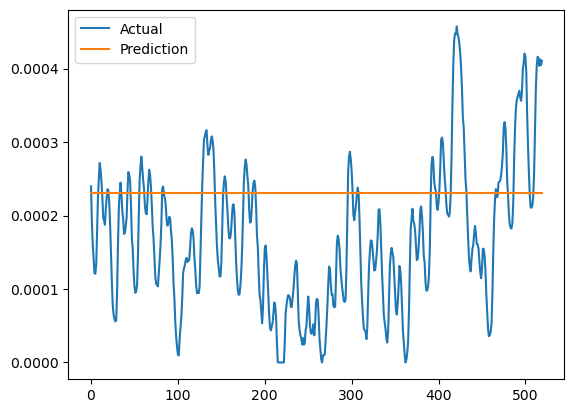

In [80]:
# Visual evalution of model on training set
start = 480
end = 1000
train_predictions = model_2(tr_in.float())
train_loss = torch.nn.MSELoss()(train_predictions.float().squeeze(), tr_out.float())
print(f'Test Loss: {train_loss.item()}')
plt.plot(tr_out[start:end],label = "Actual")
plt.plot(train_predictions.detach()[start:end],label = "Prediction"),plt.legend()

Test Loss: 1.0238978553900324e-09


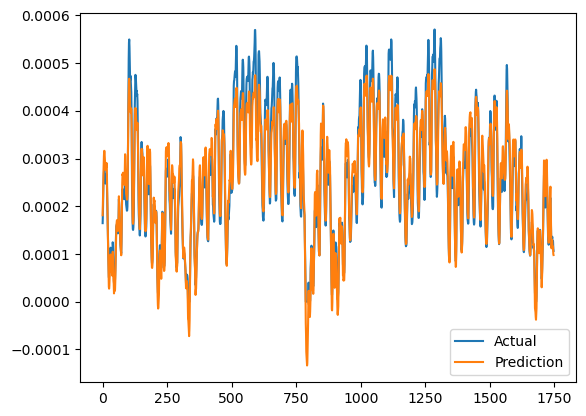

In [58]:
# Evaluate the model on the test set
s = 0
e = 15000
test_predictions = model(te_in.float())
test_loss = torch.nn.MSELoss()(test_predictions.float().squeeze(), te_out.float())
print(f'Test Loss: {test_loss.item()}')
plt.plot(te_out[s:e],label = "Actual")
plt.plot(test_predictions.detach()[s:e],label = "Prediction")
plt.legend()